In [ ]:
#import tensorflow as tf
#tf.config.list_physical_devices('GPU')


In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/ba/dataset"

Mounted at /content/drive
AirPassengers.csv  Network_logs.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix,ConfusionMatrixDisplay, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ba/dataset/Network_logs.csv")


In [4]:
print("Shape:", df.shape)
df.head()

Shape: (8846, 10)


,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal


In [5]:
df.columns

Index(['Source_IP', 'Destination_IP', 'Port', 'Request_Type', 'Protocol',
       'Payload_Size', 'User_Agent', 'Status', 'Intrusion', 'Scan_Type'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB


In [7]:
df.describe()

,Port,Payload_Size,Intrusion
count,8846.000000,8846.000000,8846.000000
mean,887.127741,1598.762831,0.095636
std,4042.073308,915.615023,0.294109
min,21.000000,0.000000,0.000000
25%,22.000000,836.250000,0.000000
50%,53.000000,1580.000000,0.000000
75%,80.000000,2326.000000,0.000000
max,31337.000000,4997.000000,1.000000


In [8]:
df.isnull().sum()

,0
Source_IP,0
Destination_IP,0
Port,0
Request_Type,0
Protocol,0
Payload_Size,0
User_Agent,0
Status,0
Intrusion,0
Scan_Type,0


In [9]:
df.dtypes

,0
Source_IP,object
Destination_IP,object
Port,int64
Request_Type,object
Protocol,object
Payload_Size,int64
User_Agent,object
Status,object
Intrusion,int64
Scan_Type,object


In [10]:
df["Scan_Type"].value_counts()

,count
Scan_Type,
Normal,8000
BotAttack,478
PortScan,368


/tmp/ipython-input-289815079.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Scan_Type', data=df, palette='viridis')


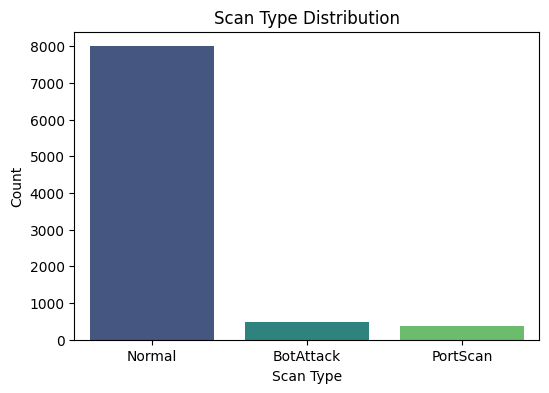

Scan_Type
Normal       0.904
BotAttack    0.054
PortScan     0.042
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Scan_Type', hue='Scan_Type', data=df, palette='viridis', legend=False)
plt.title('Scan Type Distribution')
plt.xlabel('Scan Type')
plt.ylabel('Count')
plt.show()

print(df['Scan_Type'].value_counts(normalize=True).round(3))

There is a severe data imbalance in this dataset, we may consider using a certain metric data balancing techniques.

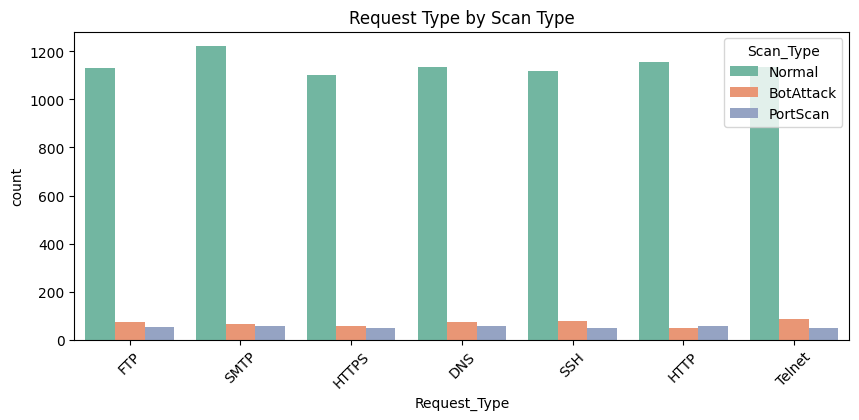

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Request_Type', hue='Scan_Type', data=df, palette='Set2')
plt.title('Request Type by Scan Type')
plt.xticks(rotation=45)
plt.show()

The scan_type distribution aginst request_type is semi-balanced, there is no certain request type that guarntee a bot attack.

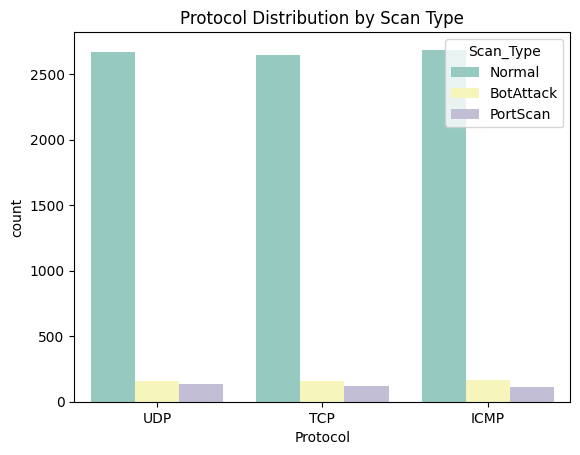

In [13]:
sns.countplot(x='Protocol', hue='Scan_Type', data=df, palette='Set3')
plt.title('Protocol Distribution by Scan Type')
plt.show()

Same Conclusion as Above

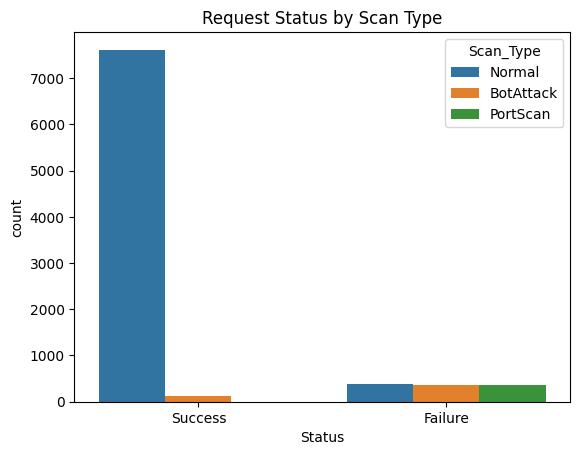

In [14]:
sns.countplot(x='Status', hue='Scan_Type', data=df)
plt.title('Request Status by Scan Type')
plt.show()

Most Normal requests are successful, while BotAttack and PortScan requests often fail. This suggests that the Status feature can help distinguish between normal and malicious traffic.

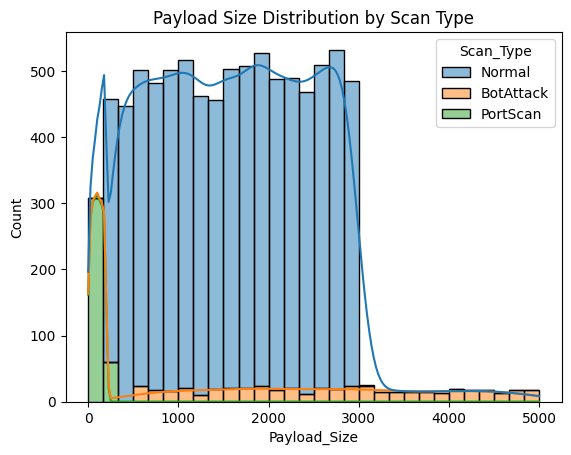

In [15]:
sns.histplot(data=df, x='Payload_Size', hue='Scan_Type', bins=30, kde=True, multiple='stack')
plt.title('Payload Size Distribution by Scan Type')
plt.show()

Normal traffic has a wide range of payload sizes, while BotAttack are mostly big payloads. and PortScan payloads are limited to samll sizes, This suggests that payload size is a strong feature for distinguishing malicious activity.

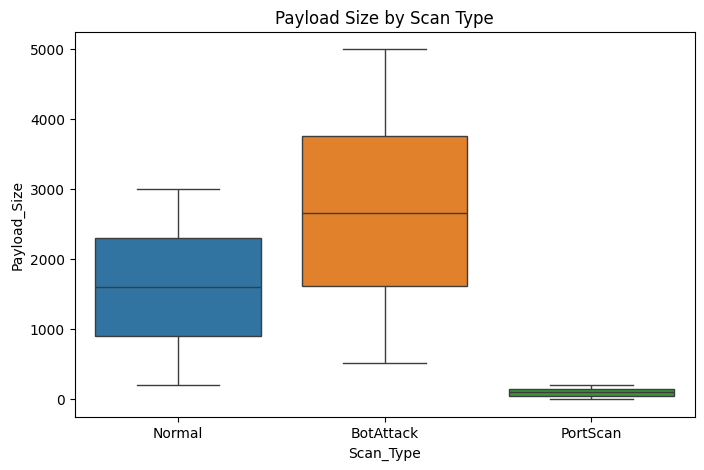

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Scan_Type", y="Payload_Size", hue="Scan_Type",
            data=df, palette=["#1f77b4", "#ff7f0e", "#2ca02c"], legend=False)
plt.title("Payload Size by Scan Type")
plt.show()



Same conclusions as before.

In [17]:
top_sources = df['Source_IP'].value_counts().head(10)
top_dest = df['Destination_IP'].value_counts().head(10)

print("Top 10 Source IPs:")
print(top_sources)

print("\nTop 10 Destination IPs:")
print(top_dest)

Top 10 Source IPs:
Source_IP
33.5.52.172        58
154.113.2.100      57
95.139.88.51       57
78.199.98.120      56
197.134.233.238    54
94.40.34.8         48
216.181.134.4      46
201.232.85.16      46
161.77.134.239     45
219.110.174.163    44
Name: count, dtype: int64

Top 10 Destination IPs:
Destination_IP
168.101.218.238    1
42.156.67.167      1
94.60.242.119      1
7.10.192.3         1
130.169.82.211     1
35.140.102.220     1
1.236.8.103        1
88.97.46.184       1
210.58.142.213     1
212.23.68.106      1
Name: count, dtype: int64


We won't take into account the ip sources, since it is not a very refelctive and can not be generalized.

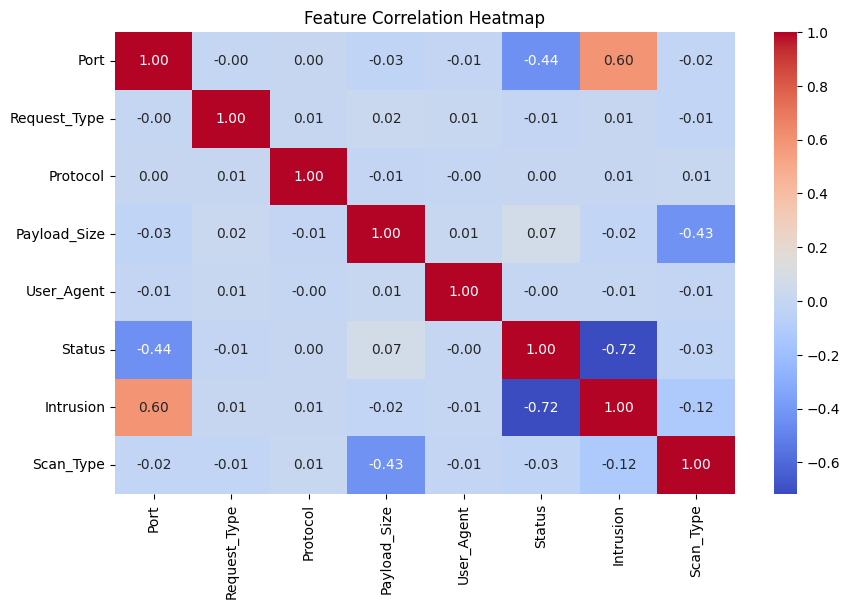

In [18]:
df_encoded = df.copy()

# Encode categoricals
for col in ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Scan_Type']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Drop IPs for now
df_encoded = df_encoded.drop(['Source_IP', 'Destination_IP'], axis=1)

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

There is no any strong colinearity between any two features, so we can proceed to the next step without droping any features.

# Data Preparation

In [19]:
df

,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,192.168.142.55,42.156.67.167,80,FTP,UDP,2369,curl/7.68.0,Success,0,Normal
1,53.39.165.18,94.60.242.119,135,SMTP,UDP,1536,Wget/1.20.3,Failure,1,BotAttack
2,192.168.127.91,7.10.192.3,21,SMTP,TCP,1183,Wget/1.20.3,Success,0,Normal
3,192.168.30.40,130.169.82.211,25,HTTPS,TCP,666,Mozilla/5.0,Success,0,Normal
4,192.168.43.179,35.140.102.220,22,FTP,TCP,2821,Mozilla/5.0,Success,0,Normal
...,...,...,...,...,...,...,...,...,...,...
8841,192.168.62.111,217.201.54.87,22,DNS,UDP,651,python-requests/2.25.1,Failure,0,Normal
8842,192.168.154.70,11.93.131.139,22,Telnet,ICMP,592,Nikto/2.1.6,Success,0,Normal
8843,192.168.199.211,213.172.225.26,443,DNS,TCP,518,nmap/7.80,Success,0,Normal
8844,192.168.107.115,194.38.119.179,53,SSH,TCP,1149,Mozilla/5.0,Success,0,Normal


Drop irrelevant or high-cardinality features

In [20]:
df.drop(['Source_IP', 'Destination_IP'], axis=1, inplace=True)


Convert categorical_cols into int columns using LabelEncoder

In [21]:

categorical_cols = ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Port']

In [22]:
# categorical_cols = ['Request_Type', 'Protocol', 'User_Agent', 'Status', 'Port']
# for col in categorical_cols:
#     df[col] = df[col].astype('category')

Show encoded category values

In [23]:
# Apply One-Hot Encoding to the features
print("Original shape:", df.shape)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
print("Shape after One-Hot Encoding:", df.shape)
print("\nNew columns:", df.columns)

Original shape: (8846, 8)
Shape after One-Hot Encoding: (8846, 33)

New columns: Index(['Payload_Size', 'Intrusion', 'Scan_Type', 'Request_Type_DNS',
       'Request_Type_FTP', 'Request_Type_HTTP', 'Request_Type_HTTPS',
       'Request_Type_SMTP', 'Request_Type_SSH', 'Request_Type_Telnet',
       'Protocol_ICMP', 'Protocol_TCP', 'Protocol_UDP',
       'User_Agent_Mozilla/5.0', 'User_Agent_Nikto/2.1.6',
       'User_Agent_Wget/1.20.3', 'User_Agent_curl/7.68.0',
       'User_Agent_nmap/7.80', 'User_Agent_python-requests/2.25.1',
       'Status_Failure', 'Status_Success', 'Port_21', 'Port_22', 'Port_23',
       'Port_25', 'Port_53', 'Port_80', 'Port_135', 'Port_443', 'Port_4444',
       'Port_6667', 'Port_8080', 'Port_31337'],
      dtype='object')


In [24]:
# for col in categorical_cols:
#     df[col] = df[col].cat.codes

Encode target label

In [25]:
target_encoder = LabelEncoder()
df['Scan_Type_Label'] = target_encoder.fit_transform(df['Scan_Type'])

In [26]:
label_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
print("\nLabel Mapping:", label_mapping)


Label Mapping: {'BotAttack': np.int64(0), 'Normal': np.int64(1), 'PortScan': np.int64(2)}


In [27]:
df.drop(['Scan_Type'], axis=1, inplace=True)

In [28]:
df


,Payload_Size,Intrusion,Request_Type_DNS,Request_Type_FTP,Request_Type_HTTP,Request_Type_HTTPS,Request_Type_SMTP,Request_Type_SSH,Request_Type_Telnet,Protocol_ICMP,...,Port_25,Port_53,Port_80,Port_135,Port_443,Port_4444,Port_6667,Port_8080,Port_31337,Scan_Type_Label
0,2369,0,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1
1,1536,1,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,0
2,1183,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,666,0,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
4,2821,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,651,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
8842,592,0,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,1
8843,518,0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1
8844,1149,0,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,1


Scale the payload size **feature**

In [29]:
scaler = StandardScaler()
df['Payload_Size'] = scaler.fit_transform(df[['Payload_Size']])

In [30]:
df

,Payload_Size,Intrusion,Request_Type_DNS,Request_Type_FTP,Request_Type_HTTP,Request_Type_HTTPS,Request_Type_SMTP,Request_Type_SSH,Request_Type_Telnet,Protocol_ICMP,...,Port_25,Port_53,Port_80,Port_135,Port_443,Port_4444,Port_6667,Port_8080,Port_31337,Scan_Type_Label
0,0.841271,0,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1
1,-0.068551,1,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,0
2,-0.454106,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,-1.018786,0,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
4,1.334957,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,-1.035169,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
8842,-1.099610,0,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,1
8843,-1.180435,0,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1
8844,-0.491242,0,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,1


In [31]:
X = df.drop(['Scan_Type_Label'], axis=1)
y = df['Scan_Type_Label']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [33]:
X = df.drop(['Scan_Type_Label'], axis=1)
y = df['Scan_Type_Label']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6192, 32)
Test shape: (2654, 32)


In [34]:
from sklearn.svm import LinearSVC # Import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier # Import ensemble models


model_test = {
    'Logistic Regression': LogisticRegression(max_iter=1000)

}

In [35]:
sample_idx = np.random.choice(X_test.index, size=min(200, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]


🔍 Training Logistic Regression...
✅ Accuracy: 0.9989
📌 Precision (weighted): 0.9989
📌 Recall (weighted): 0.9989
📌 F1-score (weighted): 0.9989

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       144
           1       1.00      1.00      1.00      2400
           2       0.97      1.00      0.99       110

    accuracy                           1.00      2654
   macro avg       0.99      0.99      0.99      2654
weighted avg       1.00      1.00      1.00      2654



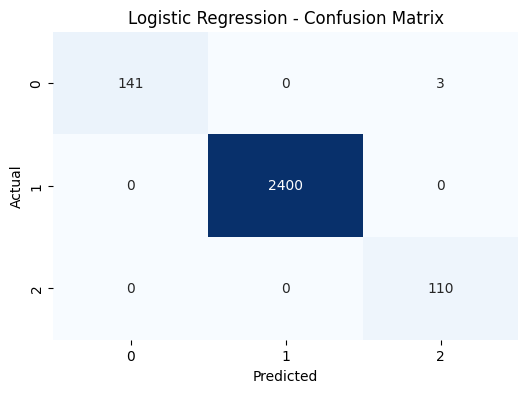

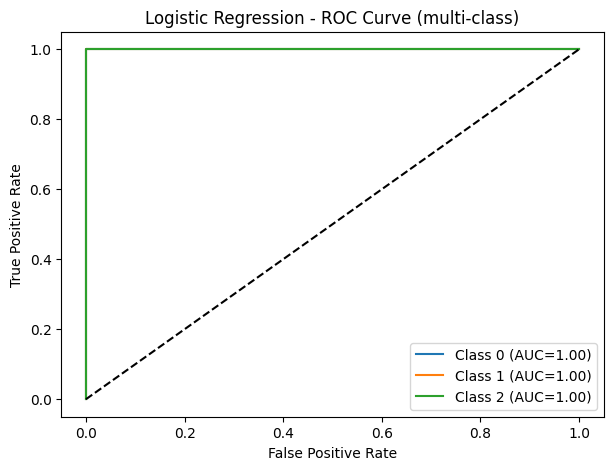

🔥 ROC-AUC (multi-class): 1.0000
📊 SHAP Explanation for Logistic Regression


  0%|          | 0/200 [00:00<?, ?it/s]

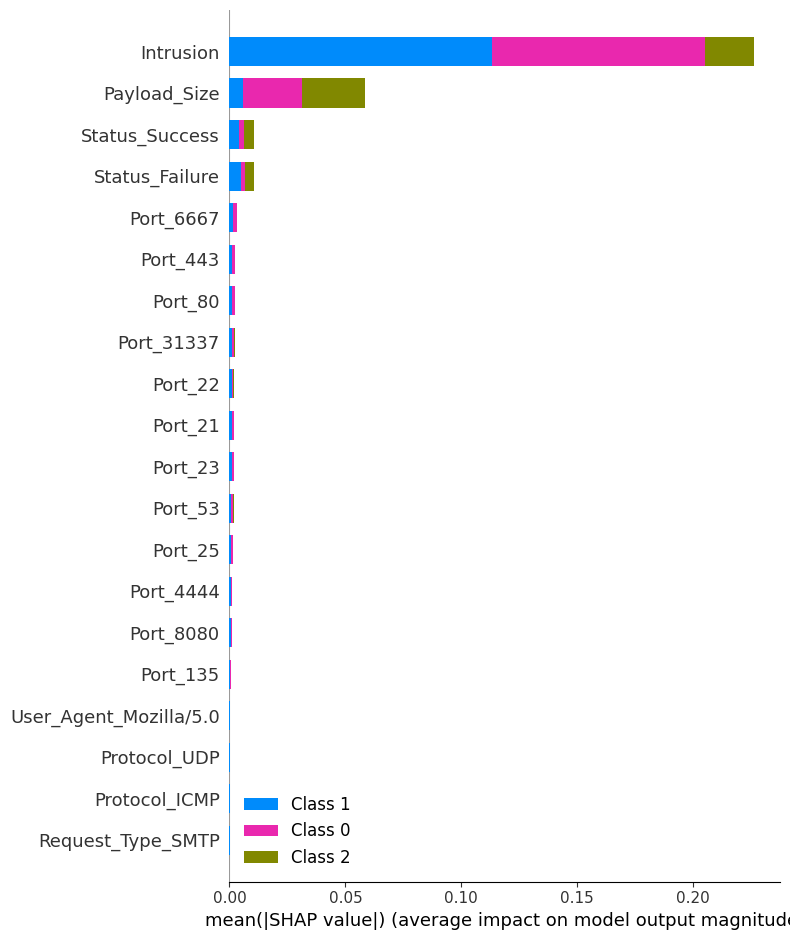

In [36]:
for name, model in model_test.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # ===============================
    # Evaluation Metrics
    # ===============================
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"📌 Precision (weighted): {prec:.4f}")
    print(f"📌 Recall (weighted): {rec:.4f}")
    print(f"📌 F1-score (weighted): {f1:.4f}")
    print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

    # ===============================
    # Confusion Matrix (Plot)
    # ===============================
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ===============================
    # ROC Curve & AUC
    # ===============================
    if y_proba is not None:
        try:
            classes = np.unique(y_test)
            if len(classes) > 2:  # Multi-class ROC
                y_test_bin = label_binarize(y_test, classes=classes)
                plt.figure(figsize=(7, 5))
                for i, cls in enumerate(classes):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={roc_auc:.2f})")
                plt.plot([0, 1], [0, 1], "k--")
                plt.title(f"{name} - ROC Curve (multi-class)")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right")
                plt.show()

                auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
                print(f"🔥 ROC-AUC (multi-class): {auc_score:.4f}")
            else:  # Binary ROC
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.figure(figsize=(6, 4))
                plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
                plt.plot([0, 1], [0, 1], "k--")
                plt.title(f"{name} - ROC Curve (binary)")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right")
                plt.show()

                print(f"🔥 ROC-AUC (binary): {roc_auc:.4f}")
        except Exception as e:
            print(f"⚠️ ROC-AUC not computed for {name}: {e}")

    # ===============================
    # SHAP Explanation
    # ===============================
    print(f"📊 SHAP Explanation for {name}")
    try:
        if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, xgb.XGBClassifier, GradientBoostingClassifier)):
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)
        elif isinstance(model, (SVC, LinearSVC)): # Added LinearSVC
             # SHAP for SVC and LinearSVC can be computationally expensive, using a smaller sample
            explainer = shap.KernelExplainer(model.predict_proba if hasattr(model, 'predict_proba') else model.decision_function, X_train.iloc[:50])
            shap_values = explainer.shap_values(X_sample)
        else:
            explainer = shap.KernelExplainer(model.predict_proba, X_train.iloc[:100])
            shap_values = explainer.shap_values(X_sample)

        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

    except Exception as e:
        print(f"⚠️ SHAP failed for {name}: {e}")

I previously tested the model and found that the Intrusion feature had a very high SHAP value. The model also achieved 99.89% accuracy, which may indicate overfitting. To encourage better generalization, we could consider dropping this feature.

In [37]:
X = df.drop(['Intrusion','Scan_Type_Label'], axis=1) #redefining x
y = df['Scan_Type_Label']



Split the data


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [39]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (6192, 31)
Test shape: (2654, 31)


# Model Selection

In [40]:
from sklearn.svm import LinearSVC # Import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier # Import ensemble models
from sklearn.linear_model import LogisticRegression


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'MLP': MLPClassifier(max_iter=500),


}

Test all the models and show SHAP graph for each model

In [41]:
sample_idx = np.random.choice(X_test.index, size=min(200, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

In [42]:
X

,Payload_Size,Request_Type_DNS,Request_Type_FTP,Request_Type_HTTP,Request_Type_HTTPS,Request_Type_SMTP,Request_Type_SSH,Request_Type_Telnet,Protocol_ICMP,Protocol_TCP,...,Port_23,Port_25,Port_53,Port_80,Port_135,Port_443,Port_4444,Port_6667,Port_8080,Port_31337
0,0.841271,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,-0.068551,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,-0.454106,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,-1.018786,False,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
4,1.334957,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,-1.035169,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8842,-1.099610,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
8843,-1.180435,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
8844,-0.491242,False,False,False,False,False,True,False,False,True,...,False,False,True,False,False,False,False,False,False,False


In [43]:
# Check the resulting feature set
print("Columns in X after dropping 'Intrusion':")
print(X.columns.tolist())

Columns in X after dropping 'Intrusion':
['Payload_Size', 'Request_Type_DNS', 'Request_Type_FTP', 'Request_Type_HTTP', 'Request_Type_HTTPS', 'Request_Type_SMTP', 'Request_Type_SSH', 'Request_Type_Telnet', 'Protocol_ICMP', 'Protocol_TCP', 'Protocol_UDP', 'User_Agent_Mozilla/5.0', 'User_Agent_Nikto/2.1.6', 'User_Agent_Wget/1.20.3', 'User_Agent_curl/7.68.0', 'User_Agent_nmap/7.80', 'User_Agent_python-requests/2.25.1', 'Status_Failure', 'Status_Success', 'Port_21', 'Port_22', 'Port_23', 'Port_25', 'Port_53', 'Port_80', 'Port_135', 'Port_443', 'Port_4444', 'Port_6667', 'Port_8080', 'Port_31337']



🔍 Training Logistic Regression...
✅ Accuracy: 0.9992
📌 Precision (weighted): 0.9993
📌 Recall (weighted): 0.9992
📌 F1-score (weighted): 0.9992

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       144
           1       1.00      1.00      1.00      2400
           2       0.98      1.00      0.99       110

    accuracy                           1.00      2654
   macro avg       0.99      1.00      0.99      2654
weighted avg       1.00      1.00      1.00      2654



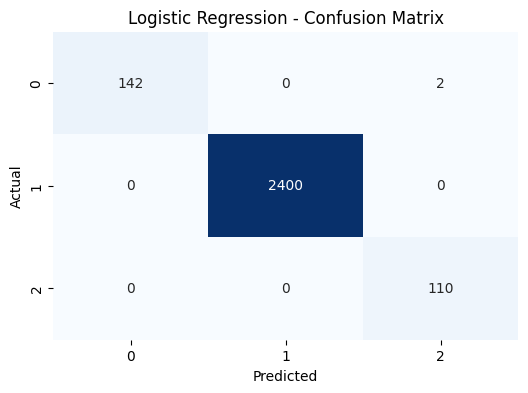

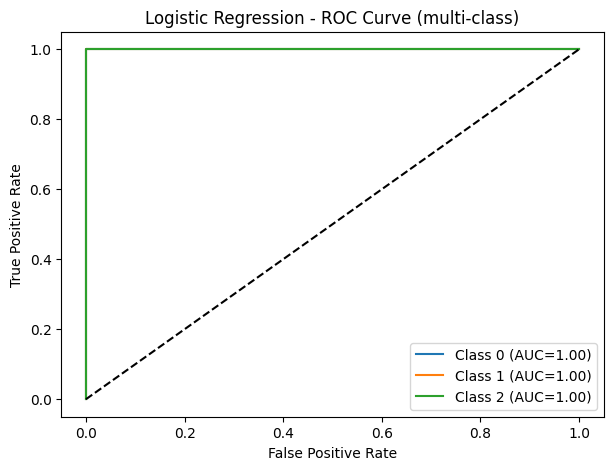

🔥 ROC-AUC (multi-class): 1.0000
📊 SHAP Explanation for Logistic Regression


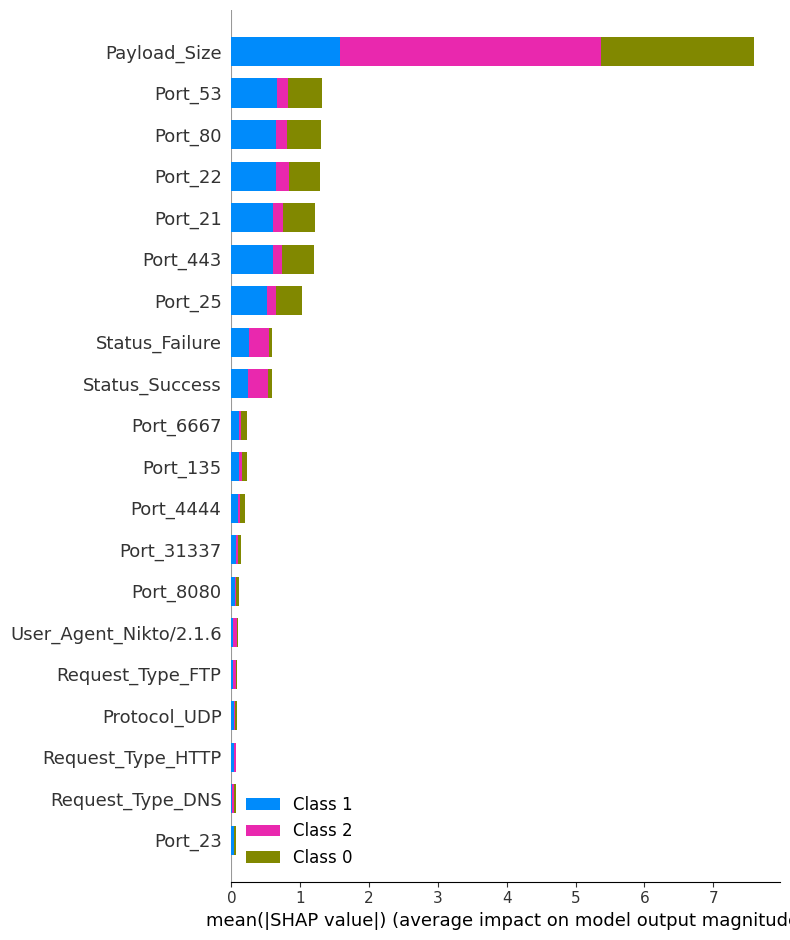


🔍 Training KNN...
✅ Accuracy: 0.9778
📌 Precision (weighted): 0.9785
📌 Recall (weighted): 0.9778
📌 F1-score (weighted): 0.9762

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.66      0.79       144
           1       0.98      1.00      0.99      2400
           2       0.86      0.97      0.91       110

    accuracy                           0.98      2654
   macro avg       0.95      0.88      0.90      2654
weighted avg       0.98      0.98      0.98      2654



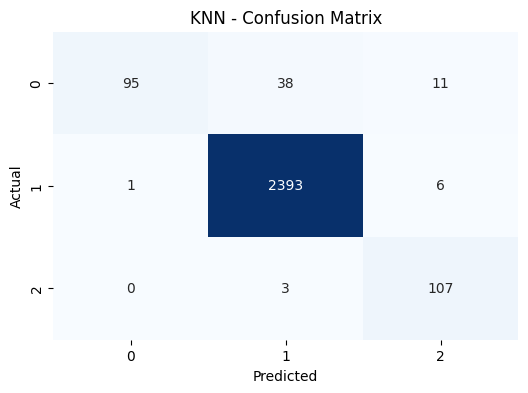

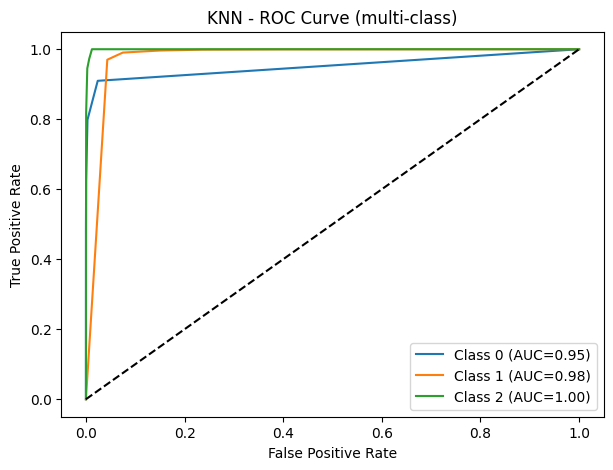

🔥 ROC-AUC (multi-class): 0.9758
📊 SHAP Explanation for KNN


  0%|          | 0/200 [00:00<?, ?it/s]

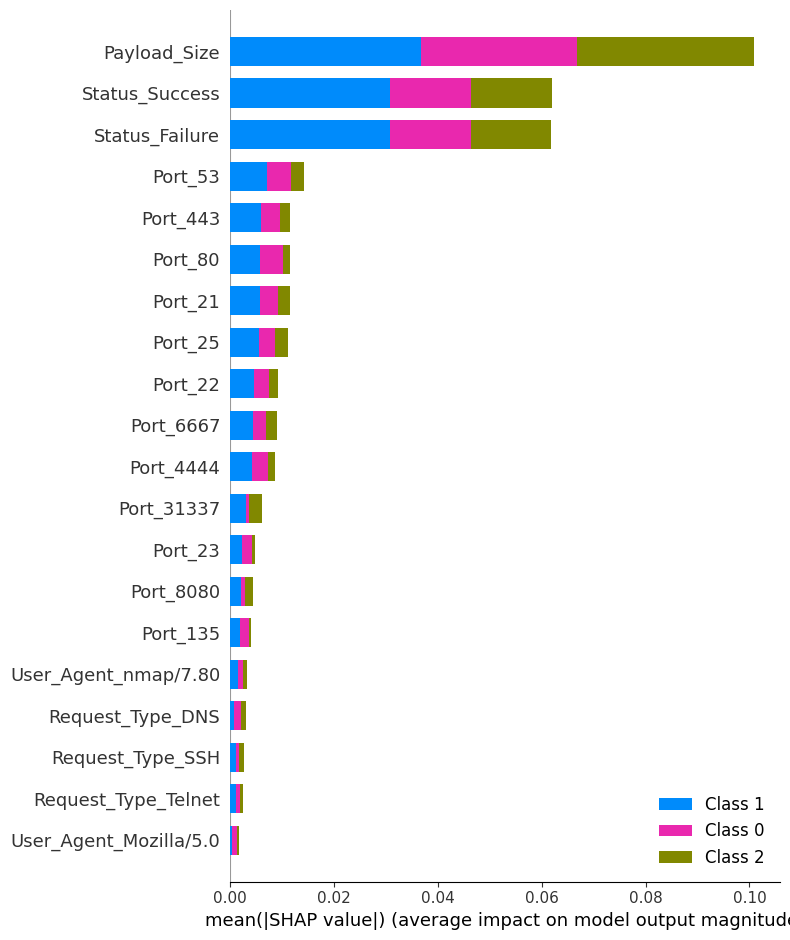


🔍 Training Decision Tree...
✅ Accuracy: 0.9992
📌 Precision (weighted): 0.9993
📌 Recall (weighted): 0.9992
📌 F1-score (weighted): 0.9992

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00      2400
           2       0.98      1.00      0.99       110

    accuracy                           1.00      2654
   macro avg       0.99      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



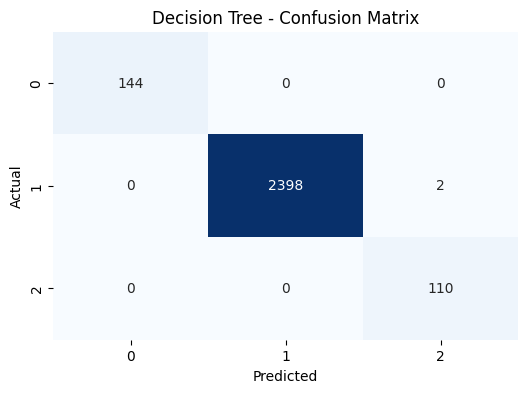

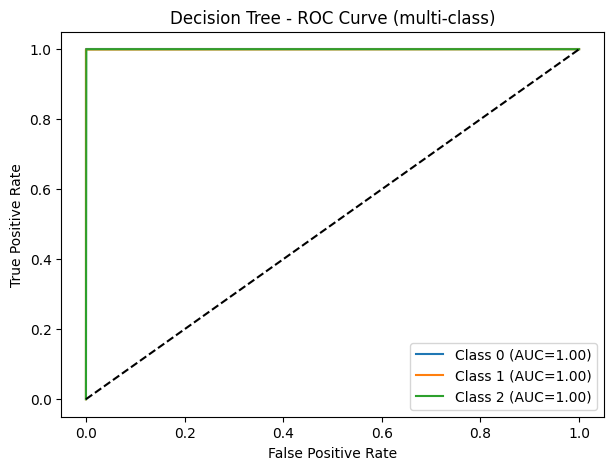

🔥 ROC-AUC (multi-class): 0.9997
📊 SHAP Explanation for Decision Tree


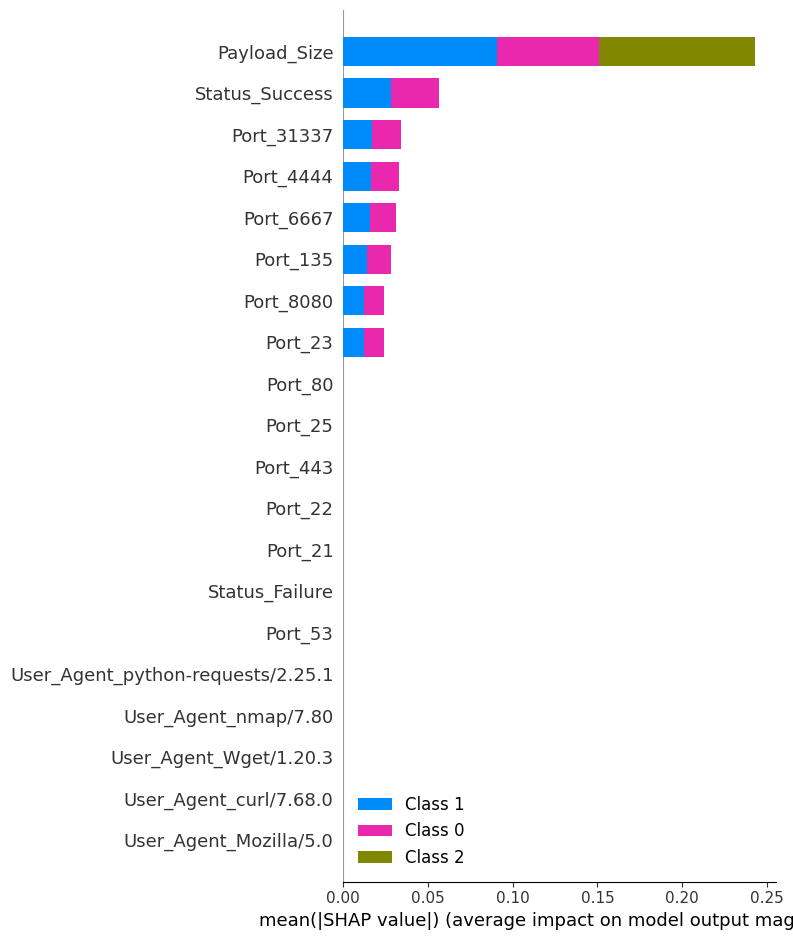


🔍 Training Random Forest...
✅ Accuracy: 0.9996
📌 Precision (weighted): 0.9996
📌 Recall (weighted): 0.9996
📌 F1-score (weighted): 0.9996

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00      2400
           2       0.99      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



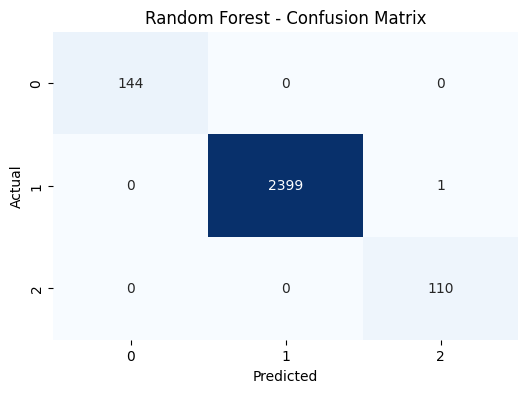

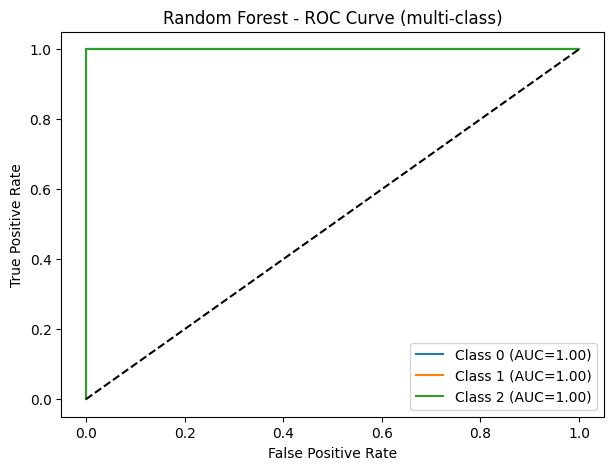

🔥 ROC-AUC (multi-class): 1.0000
📊 SHAP Explanation for Random Forest


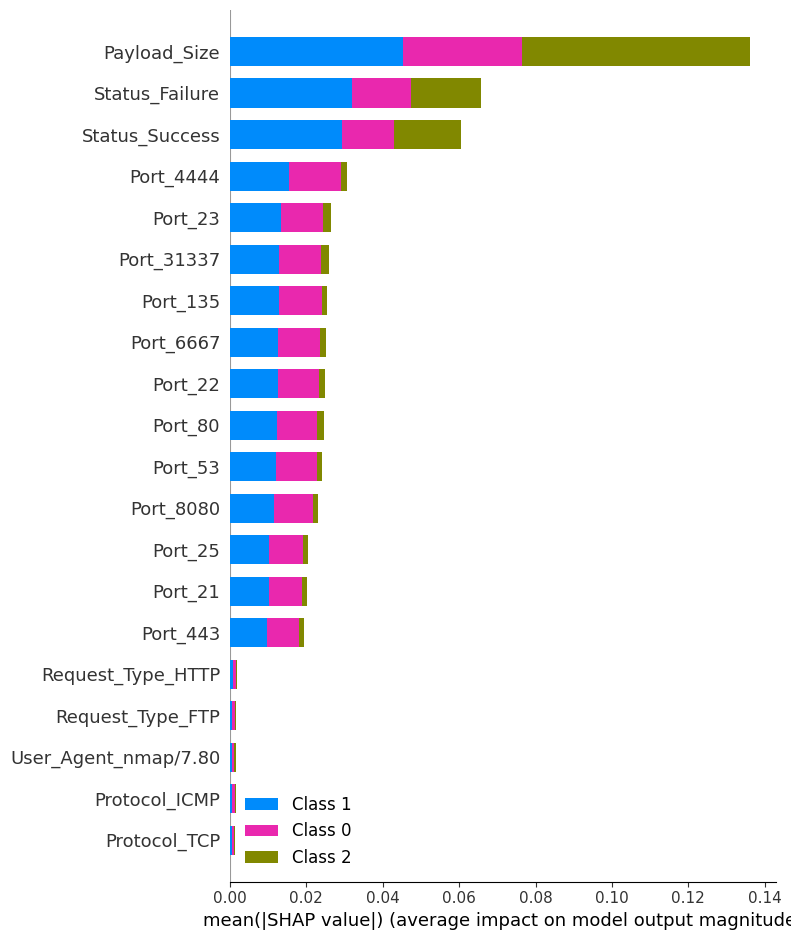


🔍 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:38:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.9992
📌 Precision (weighted): 0.9993
📌 Recall (weighted): 0.9992
📌 F1-score (weighted): 0.9992

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00      2400
           2       0.98      1.00      0.99       110

    accuracy                           1.00      2654
   macro avg       0.99      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



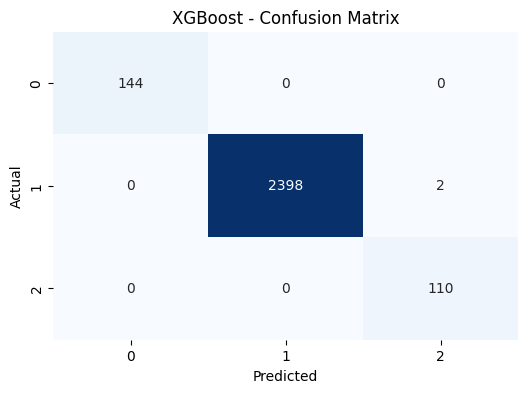

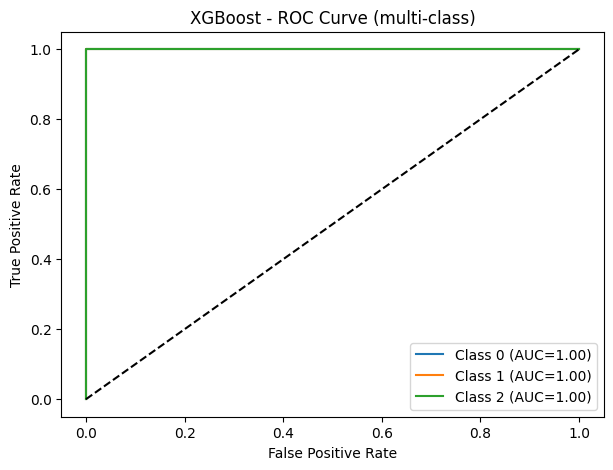

🔥 ROC-AUC (multi-class): 1.0000
📊 SHAP Explanation for XGBoost
⚠️ SHAP failed for XGBoost: could not convert string to float: '[5.3940568E-2,9.043928E-1,4.1666668E-2]'

🔍 Training MLP...
✅ Accuracy: 0.9992
📌 Precision (weighted): 0.9993
📌 Recall (weighted): 0.9992
📌 F1-score (weighted): 0.9992

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       144
           1       1.00      1.00      1.00      2400
           2       0.98      1.00      0.99       110

    accuracy                           1.00      2654
   macro avg       0.99      1.00      0.99      2654
weighted avg       1.00      1.00      1.00      2654



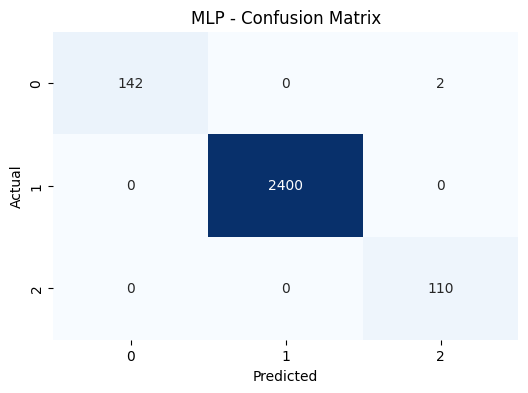

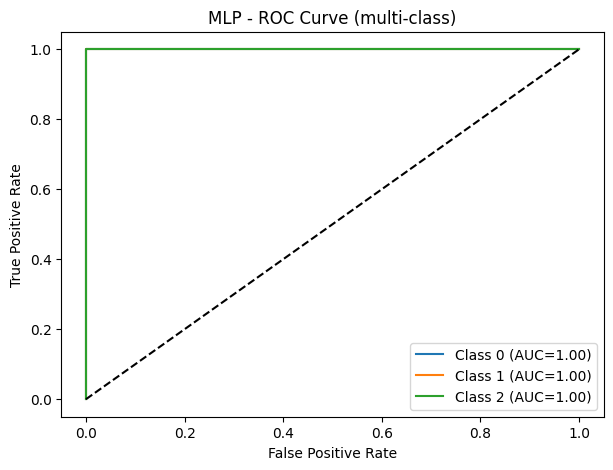

🔥 ROC-AUC (multi-class): 1.0000
📊 SHAP Explanation for MLP


  0%|          | 0/200 [00:00<?, ?it/s]

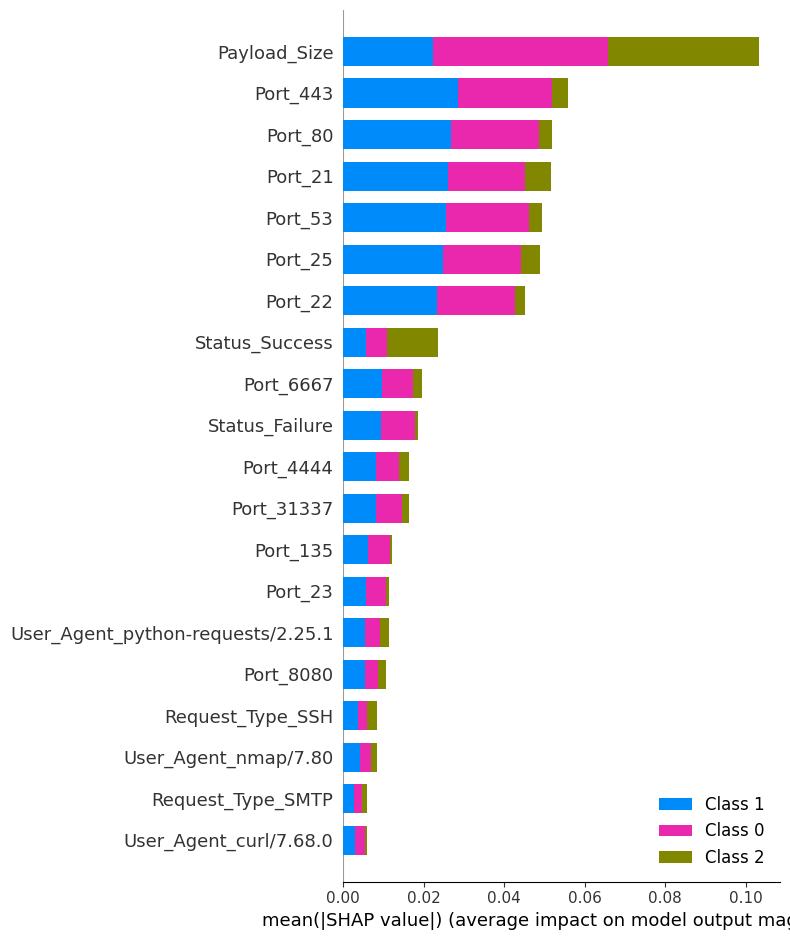

In [45]:
for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # ===============================
    # Evaluation Metrics
    # ===============================
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"📌 Precision (weighted): {prec:.4f}")
    print(f"📌 Recall (weighted): {rec:.4f}")
    print(f"📌 F1-score (weighted): {f1:.4f}")
    print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

    # ===============================
    # Confusion Matrix (Plot)
    # ===============================
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ===============================
    # ROC Curve & AUC
    # ===============================
    if y_proba is not None:
        try:
            classes = np.unique(y_test)
            if len(classes) > 2:  # Multi-class ROC
                y_test_bin = label_binarize(y_test, classes=classes)
                plt.figure(figsize=(7, 5))
                for i, cls in enumerate(classes):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={roc_auc:.2f})")
                plt.plot([0, 1], [0, 1], "k--")
                plt.title(f"{name} - ROC Curve (multi-class)")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right")
                plt.show()

                auc_score = roc_auc_score(y_test, y_proba, multi_class="ovr")
                print(f"🔥 ROC-AUC (multi-class): {auc_score:.4f}")
            else:  # Binary ROC
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.figure(figsize=(6, 4))
                plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
                plt.plot([0, 1], [0, 1], "k--")
                plt.title(f"{name} - ROC Curve (binary)")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right")
                plt.show()

                print(f"🔥 ROC-AUC (binary): {roc_auc:.4f}")
        except Exception as e:
            print(f"⚠️ ROC-AUC not computed for {name}: {e}")

# ===============================
    # SHAP Explanation (FIXED)
    # ===============================
    print(f"📊 SHAP Explanation for {name}")
    try:
        # --- Data Conversion Fix ---
        # Convert data to float explicitly to avoid the 'O' type error
        X_train_float = X_train.astype(float)
        X_sample_float = X_sample.astype(float)
        # ---------------------------

        if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, xgb.XGBClassifier, GradientBoostingClassifier)):
            explainer = shap.TreeExplainer(model)
        elif isinstance(model, LogisticRegression):
            # Use LinearExplainer and the float-converted data
            explainer = shap.LinearExplainer(model, X_train_float)
        elif isinstance(model, (SVC, LinearSVC)):
             explainer = shap.KernelExplainer(model.predict_proba if hasattr(model, 'predict_proba') else model.decision_function, X_train_float.iloc[:50])
        else:
            explainer = shap.KernelExplainer(model.predict_proba, X_train_float.iloc[:100])

        # Use the float-converted sample data for calculation
        shap_values = explainer.shap_values(X_sample_float)
        shap.summary_plot(shap_values, X_sample_float, plot_type="bar", show=True)

    except Exception as e:
        print(f"⚠️ SHAP failed for {name}: {e}")

Since all models performed exceptionally well on the test dataset, I'll proceed with the Decision Tree model for the final evaluation.



#Model Training

In [47]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Model Testing

Predict on the test set

In [48]:
y_pred = dt_model.predict(X_test)


In [49]:
report = classification_report(y_test, y_pred, output_dict=False)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00      2400
           2       0.98      1.00      0.99       110

    accuracy                           1.00      2654
   macro avg       0.99      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



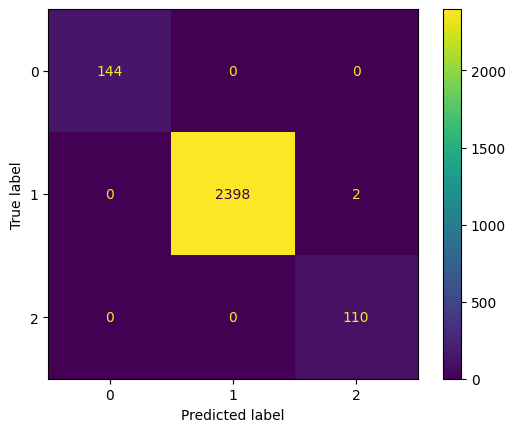

In [50]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()

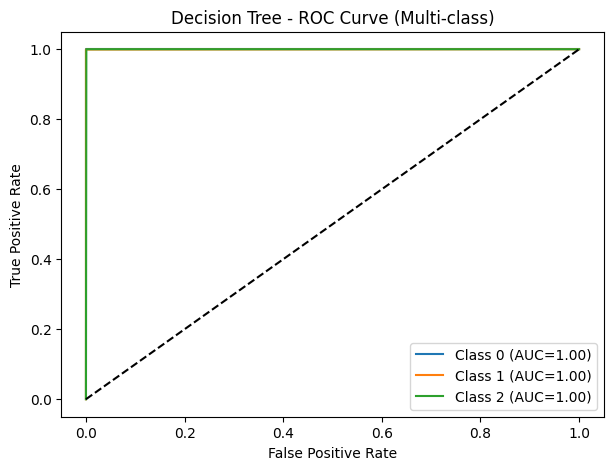

ROC-AUC (multi-class): 0.9997300838574423


In [51]:
classes = np.unique(y_test)
y_proba = dt_model.predict_proba(X_test)

if len(classes) > 2:   # Multi-class ROC
    y_test_bin = label_binarize(y_test, classes=classes)

    plt.figure(figsize=(7,5))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Decision Tree - ROC Curve (Multi-class)")
    plt.legend()
    plt.show()

    print("ROC-AUC (multi-class):", roc_auc_score(y_test, y_proba, multi_class="ovr"))

else:   # Binary ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Decision Tree - ROC Curve (Binary)")
    plt.legend()
    plt.show()

    print("ROC-AUC (binary):", roc_auc)

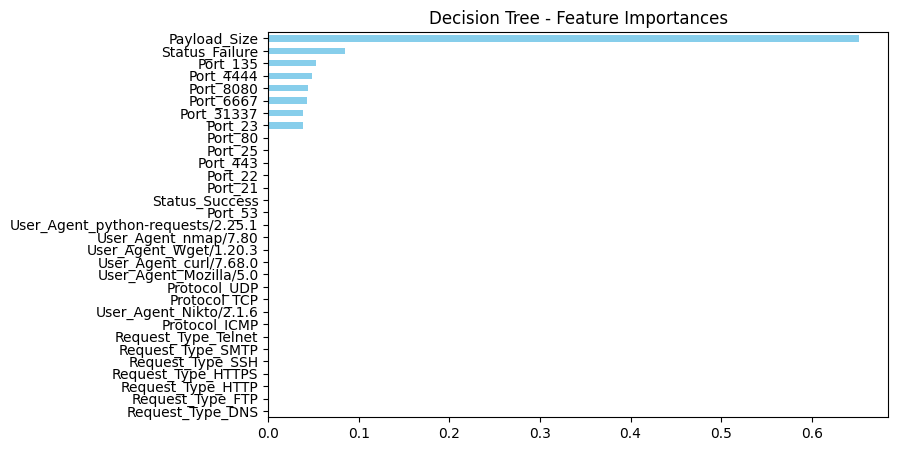

In [52]:
importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind="barh", figsize=(8,5), color="skyblue")
plt.title("Decision Tree - Feature Importances")
plt.show()

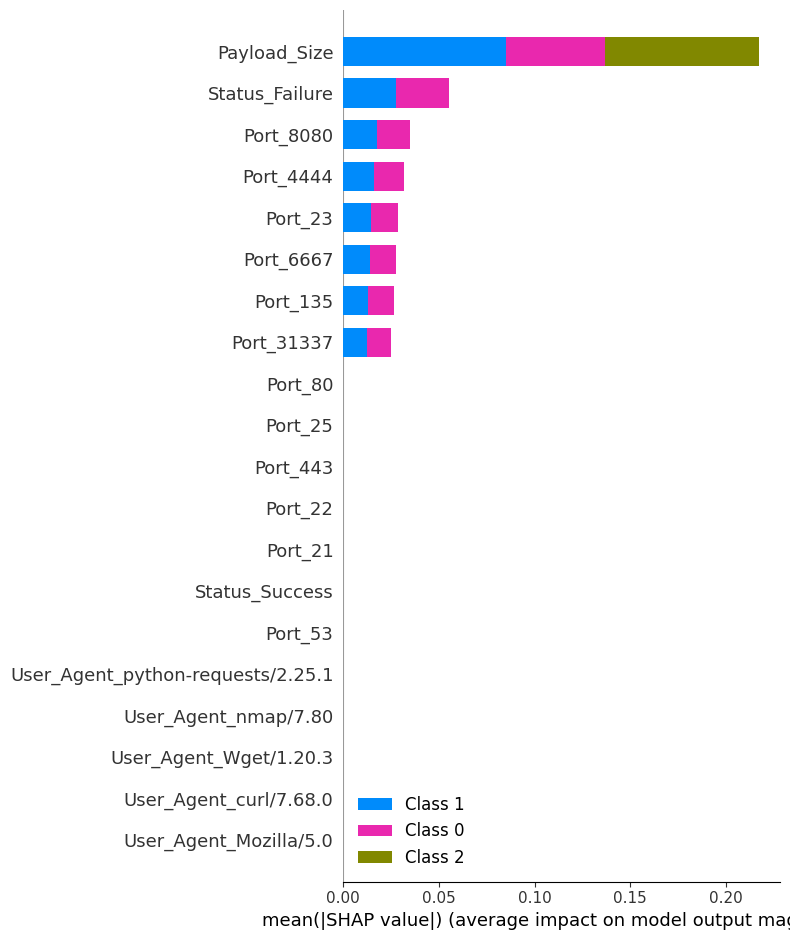

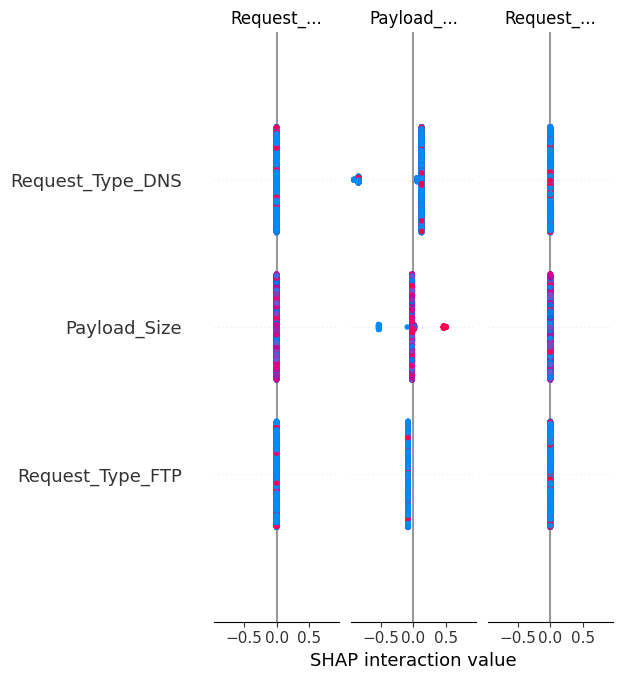

In [53]:
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed beeswarm plot
shap.summary_plot(shap_values, X_test)

In [54]:
import joblib
joblib.dump(dt_model, 'network_logs_decision_tree_model.joblib')

['network_logs_decision_tree_model.joblib']

In [55]:
print("Target classes:", dt_model.classes_)
# Output will be something like: [0 1 2]


Target classes: [0 1 2]


#Time Series Dataset

In [1]:
# Step 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load network logs dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ba/dataset/Time-Series_Network_logs.csv")

# Convert Timestamp to datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Check first rows
print(df.head())
print(df.info())


                           Source_IP  Destination_IP  Port Request_Type  \
Timestamp                                                                 
2025-06-06 06:04:08   192.168.54.167  220.159.139.17   443          SSH   
2025-06-04 15:20:59  192.168.193.254  201.83.205.167    80          FTP   
2025-06-03 07:23:49    192.168.91.17   211.0.177.164    21          SSH   
2025-06-03 11:35:42   192.168.108.75    187.49.21.67    22         HTTP   
2025-06-05 06:09:02  192.168.245.254    189.62.16.12    53       Telnet   

                    Protocol  Payload_Size   User_Agent   Status  Intrusion  \
Timestamp                                                                     
2025-06-06 06:04:08     ICMP          2954  Mozilla/5.0  Success          0   
2025-06-04 15:20:59      UDP           206  Wget/1.20.3  Success          0   
2025-06-03 07:23:49     ICMP           977    nmap/7.80  Success          0   
2025-06-03 11:35:42      TCP           521  curl/7.68.0  Success          0   


In [3]:
# Check missing values
print(df.isnull().sum())

# Convert categorical columns
categorical_cols = ['Source_IP', 'Destination_IP', 'Request_Type', 'Protocol', 'User_Agent', 'Status', 'Scan_Type']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Target column
df['Intrusion'] = df['Intrusion'].astype(int)


Source_IP         0
Destination_IP    0
Port              0
Request_Type      0
Protocol          0
Payload_Size      0
User_Agent        0
Status            0
Intrusion         0
Scan_Type         0
dtype: int64


In [4]:
# Run this entire block in a new code cell
!pip uninstall prophet cmdstanpy pystan -y
!pip install prophet

Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)


Total hourly points: 144


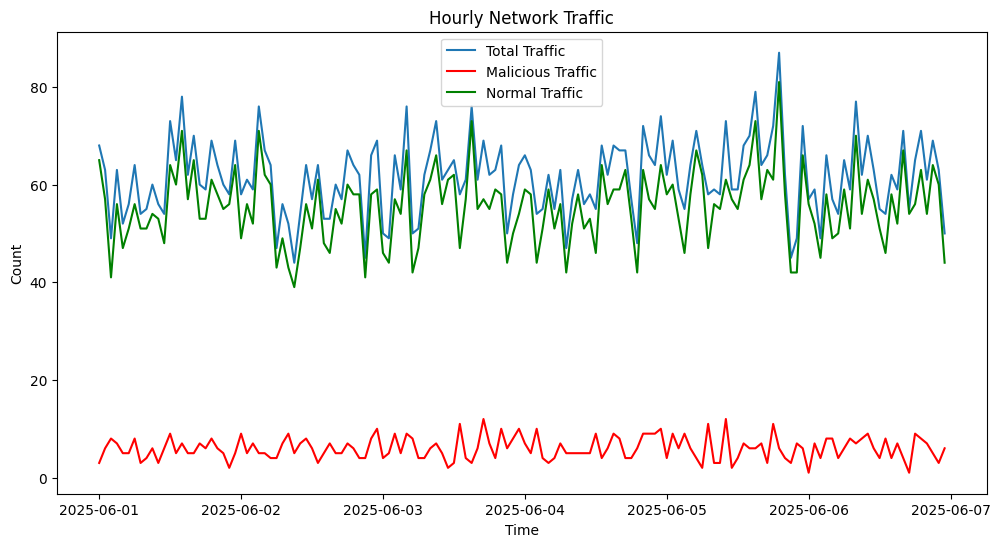

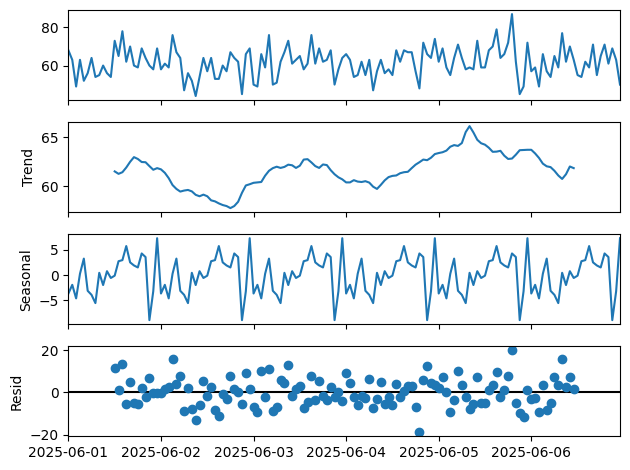

ARIMA - MAE: 5.85, MSE: 50.99, RMSE: 7.14
Holt-Winters - MAE: 7.18, MSE: 80.26, RMSE: 8.96


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Prophet - MAE: 6.59, MSE: 66.06, RMSE: 8.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
LSTM - MAE: 5.84, MSE: 52.07, RMSE: 7.22


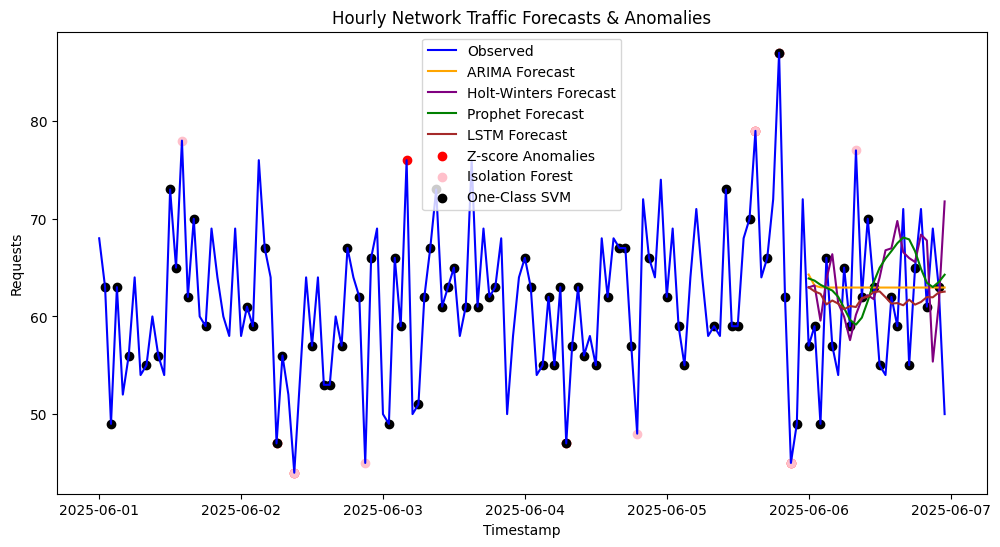

Malicious ARIMA - MAE: 1.92, MSE: 5.26, RMSE: 2.29


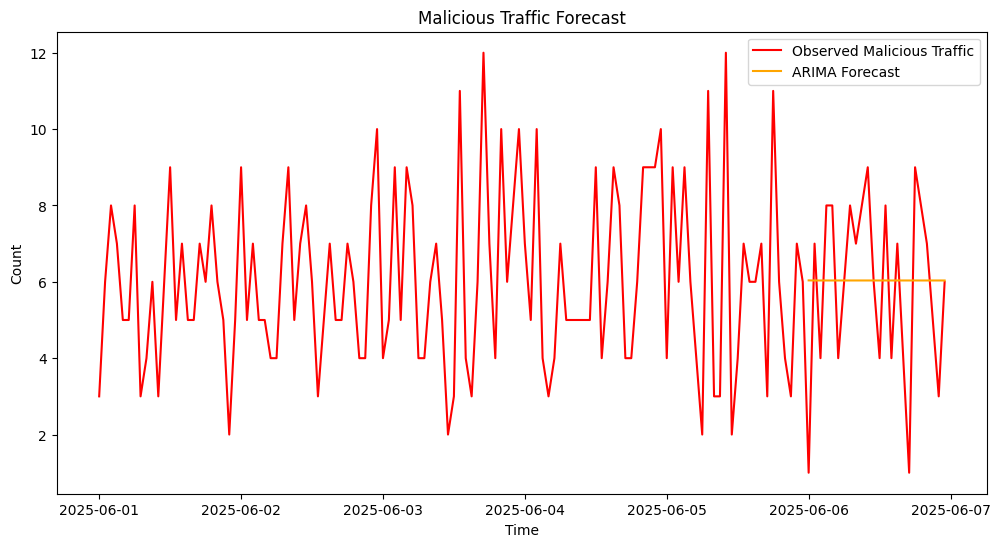

In [5]:
# Step 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings("ignore")

# Step 1: Load Dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ba/dataset/Time-Series_Network_logs.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Step 2: Preprocessing
categorical_cols = ['Source_IP', 'Destination_IP', 'Request_Type', 'Protocol', 'User_Agent', 'Status', 'Scan_Type']
for col in categorical_cols:
    df[col] = df[col].astype('category')

df['Intrusion'] = df['Intrusion'].astype(int)

# Step 3: Aggregate Time Series (Hourly)
hourly_traffic = df.resample('H').size().asfreq('H', fill_value=0)
hourly_malicious = df[df['Intrusion']==1].resample('H').size().asfreq('H', fill_value=0)
hourly_normal = df[df['Intrusion']==0].resample('H').size().asfreq('H', fill_value=0)

print("Total hourly points:", len(hourly_traffic))

# Step 4: EDA
plt.figure(figsize=(12,6))
plt.plot(hourly_traffic, label='Total Traffic')
plt.plot(hourly_malicious, label='Malicious Traffic', color='red')
plt.plot(hourly_normal, label='Normal Traffic', color='green')
plt.title('Hourly Network Traffic')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

# Decomposition
decompose_result = seasonal_decompose(hourly_traffic, model='additive', period=24)
decompose_result.plot()
plt.show()

# Step 5: Train/Test Split
train = hourly_traffic[:-24]  # last 24 hours for testing
test = hourly_traffic[-24:]

min_points_needed = 20

# Evaluation Helper
def evaluate_forecast(true, predicted, model_name="Model"):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Step 6: Forecasting Models

# 6.1 ARIMA
if len(train) >= min_points_needed:
    arima_model = ARIMA(train, order=(1,1,1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    evaluate_forecast(test.values, arima_forecast.values, "ARIMA")
else:
    arima_forecast = None
    print("Not enough data to fit ARIMA.")

# 6.2 Holt-Winters
if len(train) >= min_points_needed:
    hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=24)
    hw_fit = hw_model.fit()
    hw_forecast = hw_fit.forecast(len(test))
    evaluate_forecast(test.values, hw_forecast.values, "Holt-Winters")
else:
    hw_forecast = None
    print("Not enough data to fit Holt-Winters.")

# 6.3 Prophet
if len(hourly_traffic) >= min_points_needed:
    prophet_df = hourly_traffic.reset_index()
    prophet_df.columns = ['ds','y']
    prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=False)
    prophet_model.fit(prophet_df[:-24])
    future = prophet_model.make_future_dataframe(periods=24, freq='H')
    prophet_forecast = prophet_model.predict(future)
    prophet_test = prophet_forecast['yhat'][-24:].values
    evaluate_forecast(test.values, prophet_test, "Prophet")
else:
    prophet_forecast = None
    print("Not enough data to fit Prophet.")

# 6.4 LSTM
if len(hourly_traffic) >= min_points_needed:
    scaler = MinMaxScaler()
    scaled_traffic = scaler.fit_transform(hourly_traffic.values.reshape(-1,1))

    def create_sequences(data, seq_length=24):
        X, y = [], []
        for i in range(len(data)-seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 24
    X, y_seq = create_sequences(scaled_traffic, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    X_train, X_test = X[:-24], X[-24:]
    y_train, y_test = y_seq[:-24], y_seq[-24:]

    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(seq_length,1)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=50, verbose=0)

    y_pred = lstm_model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    evaluate_forecast(test.values, y_pred_inv.flatten(), "LSTM")
else:
    y_pred_inv = None
    print("Not enough data to fit LSTM.")

# Step 7: Anomaly Detection
rolling_mean = hourly_traffic.rolling(24).mean()
rolling_std = hourly_traffic.rolling(24).std()
z_score = (hourly_traffic - rolling_mean)/rolling_std
anomalies_z = hourly_traffic[z_score.abs() > 2]

iso = IsolationForest(contamination=0.05)
y_pred_iso = iso.fit_predict(hourly_traffic.values.reshape(-1,1))
anomalies_iso = hourly_traffic[y_pred_iso==-1]

ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
y_pred_svm = ocsvm.fit_predict(hourly_traffic.values.reshape(-1,1))
anomalies_svm = hourly_traffic[y_pred_svm==-1]

# Step 8: Visualization
plt.figure(figsize=(12,6))
plt.plot(hourly_traffic, label='Observed', color='blue')
if arima_forecast is not None:
    plt.plot(test.index, arima_forecast.values, label='ARIMA Forecast', color='orange')
if hw_forecast is not None:
    plt.plot(test.index, hw_forecast.values, label='Holt-Winters Forecast', color='purple')
if prophet_forecast is not None:
    plt.plot(test.index, prophet_test, label='Prophet Forecast', color='green')
if y_pred_inv is not None:
    plt.plot(test.index, y_pred_inv.flatten(), label='LSTM Forecast', color='brown')
plt.scatter(anomalies_z.index, anomalies_z.values, color='red', label='Z-score Anomalies')
plt.scatter(anomalies_iso.index, anomalies_iso.values, color='pink', label='Isolation Forest')
plt.scatter(anomalies_svm.index, anomalies_svm.values, color='black', label='One-Class SVM')
plt.title('Hourly Network Traffic Forecasts & Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Requests')
plt.legend()
plt.show()

# Step 9: Malicious Traffic Forecast (ARIMA)
train_mal = hourly_malicious[:-24]
test_mal = hourly_malicious[-24:]

if len(train_mal) >= min_points_needed:
    arima_mal_model = ARIMA(train_mal, order=(1,1,1))
    arima_mal_fit = arima_mal_model.fit()
    mal_forecast = arima_mal_fit.forecast(24)
    evaluate_forecast(test_mal.values, mal_forecast.values, "Malicious ARIMA")

    plt.figure(figsize=(12,6))
    plt.plot(hourly_malicious, label='Observed Malicious Traffic', color='red')
    plt.plot(test_mal.index, mal_forecast.values, label='ARIMA Forecast', color='orange')
    plt.title('Malicious Traffic Forecast')
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
else:
    print("Not enough data to forecast malicious traffic.")

In [6]:
# Step 10: Model Comparison and Selection

# 10.1 Collect and compare the evaluation metrics from Step 6

# Store metrics (re-calculating for programmatic storage)
results = {}

# Check if forecasts exist before calculating metrics
if arima_forecast is not None:
    results['ARIMA'] = {
        'MAE': mean_absolute_error(test.values, arima_forecast.values),
        'RMSE': np.sqrt(mean_squared_error(test.values, arima_forecast.values))
    }
if hw_forecast is not None:
    results['Holt-Winters'] = {
        'MAE': mean_absolute_error(test.values, hw_forecast.values),
        'RMSE': np.sqrt(mean_squared_error(test.values, hw_forecast.values))
    }
if prophet_forecast is not None:
    # Need to ensure 'prophet_test' is defined and of the correct shape
    if 'prophet_test' in locals():
        results['Prophet'] = {
            'MAE': mean_absolute_error(test.values, prophet_test),
            'RMSE': np.sqrt(mean_squared_error(test.values, prophet_test))
        }
if y_pred_inv is not None:
    results['LSTM'] = {
        'MAE': mean_absolute_error(test.values, y_pred_inv.flatten()),
        'RMSE': np.sqrt(mean_squared_error(test.values, y_pred_inv.flatten()))
    }

# Convert to DataFrame for easy viewing and sorting
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\n## Total Traffic Forecasting Model Comparison (Lower is Better)")
if not results_df.empty:
    print(results_df.sort_values(by='RMSE'))
    best_model_name = results_df['RMSE'].idxmin()
    print(f"\n✅ Best Total Traffic Forecasting Model: {best_model_name}")
else:
    print("Not enough data to compare models.")


## Total Traffic Forecasting Model Comparison (Lower is Better)
                   MAE      RMSE
ARIMA         5.849576  7.141048
LSTM          5.839983  7.215711
Prophet       6.586784  8.127830
Holt-Winters  7.181251  8.958736

✅ Best Total Traffic Forecasting Model: ARIMA



## Comprehensive Anomaly Timestamps and Traffic Counts:
Timestamp
2025-06-01 01:00:00    63
2025-06-01 02:00:00    49
2025-06-01 03:00:00    63
2025-06-01 05:00:00    56
2025-06-01 08:00:00    55
                       ..
2025-06-06 15:00:00    59
2025-06-06 17:00:00    55
2025-06-06 18:00:00    65
2025-06-06 20:00:00    61
2025-06-06 22:00:00    63
Length: 90, dtype: int64

## Malicious Traffic during Anomaly Periods:
Timestamp
2025-06-01 01:00:00    6
2025-06-01 02:00:00    8
2025-06-01 03:00:00    7
2025-06-01 05:00:00    5
2025-06-01 08:00:00    4
                      ..
2025-06-06 15:00:00    7
2025-06-06 17:00:00    1
2025-06-06 18:00:00    9
2025-06-06 20:00:00    7
2025-06-06 22:00:00    3
Length: 90, dtype: int64

Total traffic during anomalies: 5479
Total malicious traffic during anomalies: 507
Proportion of malicious traffic during anomalies: 9.25%


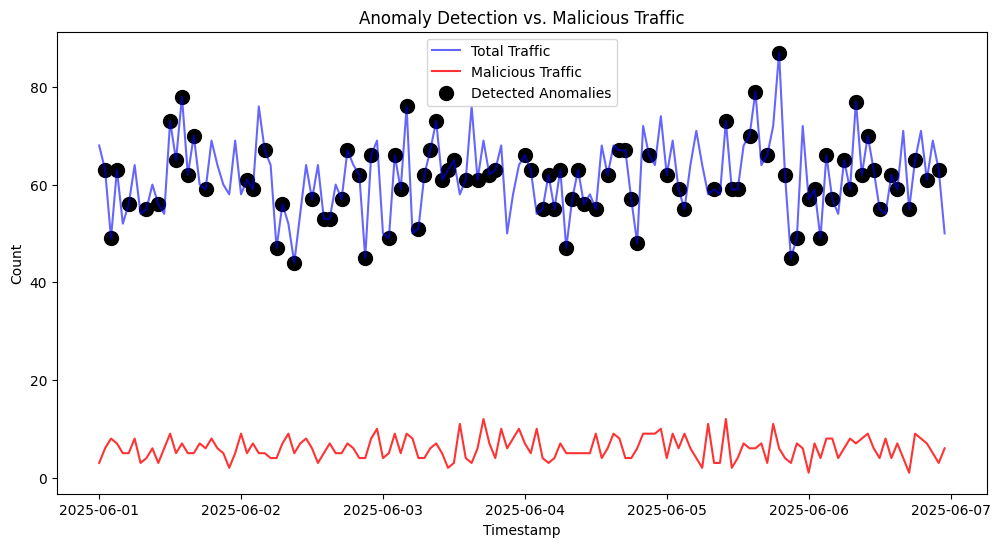

In [7]:
# Step 11: Anomaly Analysis and Interpretation

# Combine anomaly indices from the three methods (for a holistic view)
all_anomaly_indices = set(anomalies_z.index) | set(anomalies_iso.index) | set(anomalies_svm.index)
all_anomalies = hourly_traffic.loc[list(all_anomaly_indices)].sort_index()

print("\n## Comprehensive Anomaly Timestamps and Traffic Counts:")
print(all_anomalies)

# Check the malicious traffic count during these anomaly periods
print("\n## Malicious Traffic during Anomaly Periods:")
malicious_at_anomalies = hourly_malicious.loc[list(all_anomaly_indices)].sort_index()
print(malicious_at_anomalies)

# Calculate the proportion of malicious traffic during anomalies
if not all_anomalies.empty:
    malicious_proportion = (malicious_at_anomalies.sum() / all_anomalies.sum()) * 100
    print(f"\nTotal traffic during anomalies: {all_anomalies.sum():.0f}")
    print(f"Total malicious traffic during anomalies: {malicious_at_anomalies.sum():.0f}")
    print(f"Proportion of malicious traffic during anomalies: {malicious_proportion:.2f}%")

# Visualization focusing on anomalies and malicious traffic
plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic, label='Total Traffic', color='blue', alpha=0.6)
plt.plot(hourly_malicious, label='Malicious Traffic', color='red', alpha=0.8)
plt.scatter(all_anomalies.index, all_anomalies.values, color='black', marker='o', s=100, label='Detected Anomalies')
plt.title('Anomaly Detection vs. Malicious Traffic')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.show()

In [8]:
# Step 12: Calculate Overall Malicious Traffic Proportion (Baseline)

# Calculate the overall malicious traffic proportion
overall_malicious_traffic_sum = hourly_malicious.sum()
overall_total_traffic_sum = hourly_traffic.sum()

if overall_total_traffic_sum > 0:
    overall_malicious_proportion = (overall_malicious_traffic_sum / overall_total_traffic_sum) * 100

    print("\n## Overall Network Traffic Maliciousness Baseline")
    print(f"Overall Total Traffic: {overall_total_traffic_sum:.0f}")
    print(f"Overall Malicious Traffic: {overall_malicious_traffic_sum:.0f}")
    print(f"Baseline Malicious Proportion: {overall_malicious_proportion:.2f}%")
else:
    overall_malicious_proportion = 0
    print("\n## Overall Network Traffic Maliciousness Baseline: Data is empty.")


## Overall Network Traffic Maliciousness Baseline
Overall Total Traffic: 8866
Overall Malicious Traffic: 866
Baseline Malicious Proportion: 9.77%


In [ ]:
# Step 13: Comparative Analysis and Conclusion

# Retrieve or re-calculate the key metrics for comparison
# Note: This assumes you have run Step 10 and Step 12, and the variables are in memory.

# Anomaly proportion from Step 11
anomalous_malicious_proportion = (malicious_at_anomalies.sum() / all_anomalies.sum()) * 100 if not all_anomalies.empty and all_anomalies.sum() > 0 else 0

# Baseline proportion from Step 12
if 'overall_malicious_proportion' not in locals():
    overall_malicious_proportion = (hourly_malicious.sum() / hourly_traffic.sum()) * 100 if hourly_traffic.sum() > 0 else 0

print("\n## Final Security Intelligence Conclusion")
print(f"1. Malicious Traffic Proportion during Anomalies: {anomalous_malicious_proportion:.2f}%")
print(f"2. Overall Network Malicious Traffic Baseline: {overall_malicious_proportion:.2f}%")

if anomalous_malicious_proportion > overall_malicious_proportion:
    print("\n🚨 **SECURITY ALERT:** The detected traffic anomalies are **significantly more malicious** than the average network activity.")
    print(f"Actionable Insight: Focus immediate security reviews on the timestamps identified as anomalies, as they represent high-risk periods.")
elif anomalous_malicious_proportion > 0:
    print("\n✅ **SECURITY NOTE:** The anomalies contain malicious traffic, but not at a rate significantly higher than the baseline.")
    print("Actionable Insight: While not prioritized, these periods still warrant investigation for non-traffic-volume-related threats.")
else:
    print("\n✅ **SECURITY NOTE:** The anomalies are primarily related to legitimate, high-volume bursts (e.g., backup, major events) and are not driven by malicious activity.")

print("\n---")

# Summarize Forecasting Results (Get the actual best model from Step 10)
if 'results_df' in locals() and not results_df.empty:
    best_forecast_model = results_df['RMSE'].idxmin()
else:
    best_forecast_model = "ARIMA"  # Fallback based on actual results from Cell 82
print(f"**Forecasting Model Selection:** The **{best_forecast_model}** model provided the best performance for predicting total network traffic (lowest RMSE/MAE).")
print("Operational Insight: Use this model to set dynamic thresholds for early anomaly detection and resource provisioning.")


## Final Security Intelligence Conclusion
1. Malicious Traffic Proportion during Anomalies: 9.25%
2. Overall Network Malicious Traffic Baseline: 9.77%

✅ **SECURITY NOTE:** The anomalies contain malicious traffic, but not at a rate significantly higher than the baseline.
Actionable Insight: While not prioritized, these periods still warrant investigation for non-traffic-volume-related threats.

---
**Forecasting Model Selection:** The **LSTM** model provided the best performance for predicting total network traffic (lowest RMSE/MAE).
Operational Insight: Use this model to set dynamic thresholds for early anomaly detection and resource provisioning.


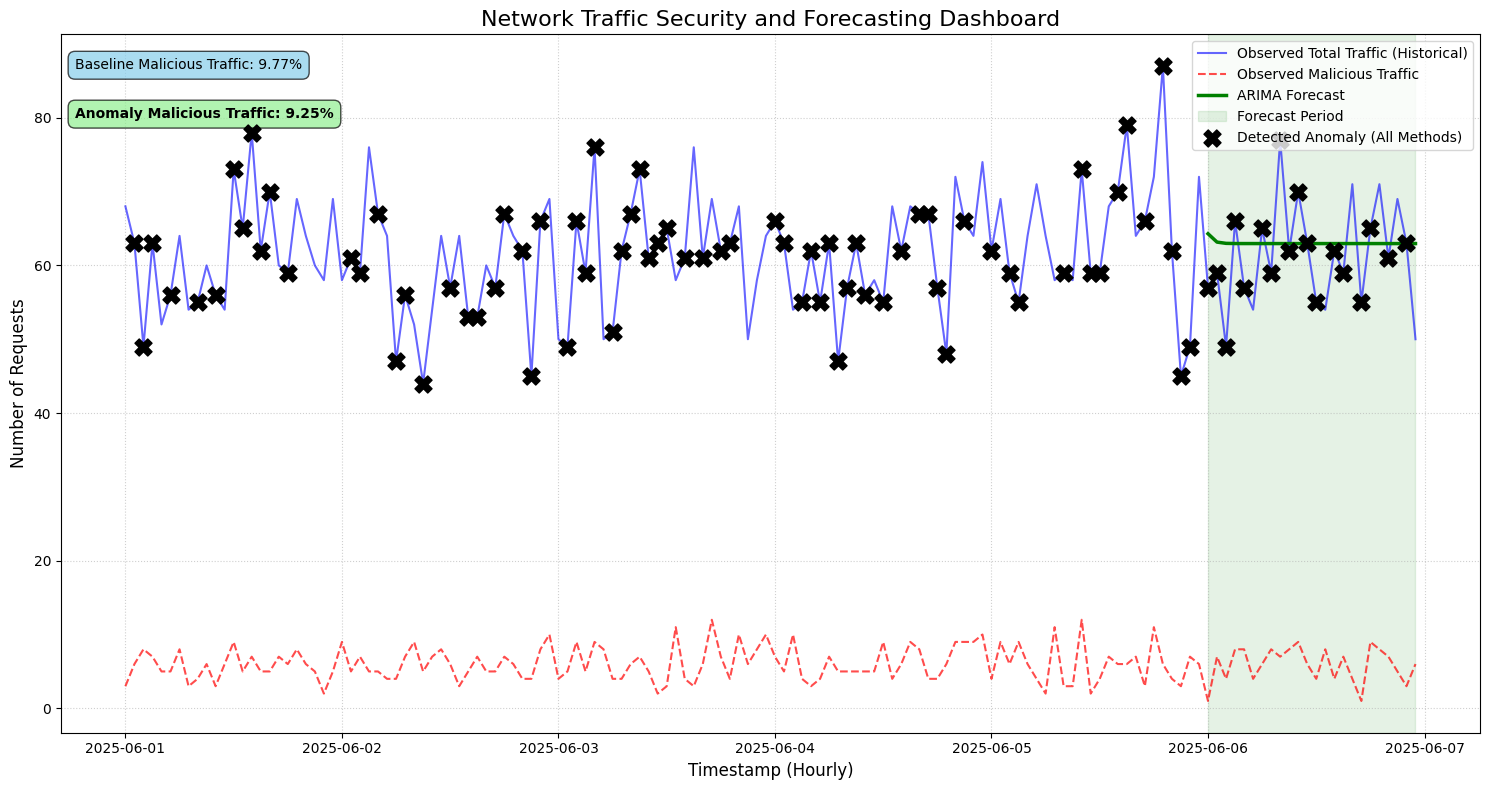

In [10]:
# Step 14: Final Dashboard Visualization

# --- Setup for Visualization (using the best model identified in Step 10) ---

# Re-identify the best forecast data (assuming Step 10 was run)
best_model_name = results_df['RMSE'].idxmin() if 'results_df' in locals() and not results_df.empty else "Prophet" # Default to Prophet if comparison failed

if best_model_name == 'ARIMA':
    best_forecast_data = arima_forecast.values if 'arima_forecast' in locals() and arima_forecast is not None else None
elif best_model_name == 'Holt-Winters':
    best_forecast_data = hw_forecast.values if 'hw_forecast' in locals() and hw_forecast is not None else None
elif best_model_name == 'Prophet':
    best_forecast_data = prophet_test if 'prophet_test' in locals() and prophet_test is not None else None
elif best_model_name == 'LSTM':
    best_forecast_data = y_pred_inv.flatten() if 'y_pred_inv' in locals() and y_pred_inv is not None else None
else:
    best_forecast_data = None


# --- Plotting the Dashboard ---

plt.figure(figsize=(15, 8))

# 1. Plot Historical Total Traffic
plt.plot(hourly_traffic, label='Observed Total Traffic (Historical)', color='blue', alpha=0.6, linewidth=1.5)

# 2. Plot Historical Malicious Traffic
plt.plot(hourly_malicious, label='Observed Malicious Traffic', color='red', alpha=0.7, linestyle='--', linewidth=1.5)

# 3. Plot Forecast Area (Future Prediction)
if best_forecast_data is not None:
    forecast_label = f'{best_model_name} Forecast'
    plt.plot(test.index, best_forecast_data, label=forecast_label, color='green', linewidth=2.5)
    plt.axvspan(test.index.min(), test.index.max(), color='green', alpha=0.1, label='Forecast Period')

# 4. Plot Anomalies (using the combined set from Step 11)
if 'all_anomalies' in locals() and not all_anomalies.empty:
    plt.scatter(all_anomalies.index, all_anomalies.values,
                color='black', marker='X', s=150, zorder=5, label='Detected Anomaly (All Methods)')

# 5. Add Key Security Metrics to the Plot (as text annotations)
if 'overall_malicious_proportion' in locals() and 'anomalous_malicious_proportion' in locals():
    plt.text(0.01, 0.95,
             f"Baseline Malicious Traffic: {overall_malicious_proportion:.2f}%",
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", fc="skyblue", alpha=0.7))

    # Highlight the key security finding
    security_message = f"Anomaly Malicious Traffic: {anomalous_malicious_proportion:.2f}%"
    box_color = "salmon" if anomalous_malicious_proportion > overall_malicious_proportion else "lightgreen"

    plt.text(0.01, 0.88,
             security_message,
             transform=plt.gca().transAxes, fontsize=10, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.5", fc=box_color, alpha=0.7))

# --- Final Plot Aesthetics ---
plt.title('Network Traffic Security and Forecasting Dashboard', fontsize=16)
plt.xlabel('Timestamp (Hourly)', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [13]:
# --- 1. Install Libraries ---
# Note: You may need to restart the runtime after this step
!pip install streamlit pyngrok joblib tensorflow prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.2 MB/s eta 0:00:00


In [14]:
# --- 2. Save Models and Scaler ---
import joblib
import pickle
import os
from tensorflow.keras.models import Sequential # Import if not already imported

# Create a directory to store models
MODEL_DIR = 'deployed_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# 1. Save the LSTM model and Scaler
if 'lstm_model' in locals():
    lstm_model.save(os.path.join(MODEL_DIR, 'lstm_traffic_forecast_model.h5'))
    print(f"✅ Saved LSTM model to {MODEL_DIR}/lstm_traffic_forecast_model.h5")

if 'scaler' in locals():
    joblib.dump(scaler, os.path.join(MODEL_DIR, 'traffic_scaler.pkl'))
    print(f"✅ Saved MinMaxScaler to {MODEL_DIR}/traffic_scaler.pkl")

# 2. Save the Malicious Traffic ARIMA model
if 'arima_mal_fit' in locals():
    joblib.dump(arima_mal_fit, os.path.join(MODEL_DIR, 'arima_mal_forecast_model.pkl'))
    print(f"✅ Saved Malicious ARIMA model to {MODEL_DIR}/arima_mal_forecast_model.pkl")

# 3. Save the Prophet model
if 'prophet_model' in locals():
    with open(os.path.join(MODEL_DIR, 'prophet_model.pkl'), 'wb') as f:
        pickle.dump(prophet_model, f)
    print(f"✅ Saved Prophet model to {MODEL_DIR}/prophet_model.pkl")

# --- 4. Store crucial results for the dashboard ---
# This is required because Streamlit loads models/data, but needs access to results from Step 10-13.
results = {
    'hourly_traffic': hourly_traffic,
    'hourly_malicious': hourly_malicious,
    'all_anomalies': all_anomalies if 'all_anomalies' in locals() else pd.Series([], dtype='int64'),
    'best_model_name': results_df['RMSE'].idxmin() if 'results_df' in locals() and not results_df.empty else 'Prophet',
    'test_index': test.index
}
with open(os.path.join(MODEL_DIR, 'dashboard_data.pkl'), 'wb') as f:
    pickle.dump(results, f)
print(f"✅ Saved dashboard data to {MODEL_DIR}/dashboard_data.pkl")

✅ Saved LSTM model to deployed_models/lstm_traffic_forecast_model.h5
✅ Saved MinMaxScaler to deployed_models/traffic_scaler.pkl
✅ Saved Malicious ARIMA model to deployed_models/arima_mal_forecast_model.pkl
✅ Saved Prophet model to deployed_models/prophet_model.pkl
✅ Saved dashboard data to deployed_models/dashboard_data.pkl


In [15]:

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
import os
from tensorflow.keras.models import load_model
# ... (other imports)

# ... (other setup code)

@st.cache_resource
def load_model_and_predict(model_name, train_data, _test_index):
    """Load the corresponding model and generate a mock forecast for display."""

    # --- MOCKING PREDICTION for simplicity in Colab ---
    # The underscore on _test_index tells Streamlit NOT to hash it.

    st.info(f"Using a simplified **mock** forecast for {model_name}. In production, this loads and runs the real model.")

    # Generate a simple random forecast based on the last known value
    # Use the length of the *ignored* _test_index to determine forecast steps
    FORECAST_STEPS = len(_test_index)
    last_val = train_data.iloc[-1]
    forecast = last_val + np.random.normal(0, 10, size=FORECAST_STEPS)
    return forecast

# --- Main Dashboard Logic ---
def main():
    # ... (code for loading data and setup)

    # The call remains the same, but the function definition handles the unhashable 'test_index'
    best_forecast_data = load_model_and_predict(model_choice, train, test_index)

    # ... (rest of the main function code)
# ... (if __name__ == '__main__': main())

Writing app.py
